# Feature egineering

Мы узнали про достаточное количество алгоритмов машинного обучения для решения  задач классификации и решрессии, и про то, как оценивать качество алгоритмов

Следующий шаг - научиться настраивать алгоритмы для получения максимального качества

В задачи unsupervised и supervised объединяет общий элемент - матрица *объекты* $\times$ *признаки* размерность $m \times n$, где $m$ - число объектов, а $n$ - число признаков

$$
X = \left[
\begin{array}{cccc}
x_{11} & x_{12} & \ldots & x_{14} \\
x_{21} & x_{22} & \ldots & x_{14} \\
\ldots & \ldots & \ldots & \ldots \\
x_{m1} & x_{m2} & \ldots & x_{mn} \\
\end{array}
\right]
$$

Таким образом, каждый объект описан признаками(фичами) в количестве $n$ штук: $x^i = (x_1, x_2, \ldots, , x_n)$. Мы уже знаем, что фичи бывают численными и категориальными.


In [1]:
import os
import shutil

import numpy as np

run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
  from google.colab import drive
  ROOT_DIR = '/content/drive'
  drive.mount(ROOT_DIR)
  print('Google drive connected')
  DRIVE_DATA_DIR = 'ml_course_data'
  root_data_dir = os.path.join(ROOT_DIR, 'MyDrive', DRIVE_DATA_DIR)
else:
  root_data_dir = os.getenv('DATA_DIR', '/srv/data')

if not os.path.exists(root_data_dir):
  raise RuntimeError('Отсутствует директория с данными')
else:
  print('Содержимое директории %s: %s' % (root_data_dir, os.listdir(root_data_dir)[:5]))

Содержимое директории /opt/ml/data: ['client_segmentation.csv', 'messages.db', 'labeled_data_corpus.csv', 'content_description.csv', 'nltk_data']


Фичи можно назвать "топливом" алгоритмов машинного обучения. Хорошие фичи позволят повысить качество решения задачи, примерно как на картинке

![ml_blackbox](img/ml_blackbox.png)


В алгоритмах машинного обучения и анализа данных часто встречаются требования к фичам входных данных
* распределение данных
* масштаб

Перед аналитиком часто стоит задача трансформации (преобразования) входных данных таким образом, чтобы удовлетворить условиям алгоритма. Игнорирование требований к входным данным приводит некорректным выводам, это основной принцип ML (и не только ML): **garbage in - garbage out**. Процесс "придумывания" фичей называется feature engineering

В этом занятии поговорим о том, как трансформировать исходный csv файл в набор фичей

# Визуализации данных

Это первый этап исследования - оценить визуально, с чем предстоит работать

Чаще всего используется визуализация `scatter plot`

In [2]:
import pandas as pd

input_dataset_df = pd.read_csv(os.path.join(root_data_dir, 'final_dataset.zip'), compression='zip')
print('num rows %d' % input_dataset_df.shape[0])

input_dataset_df.head()

num rows 100000


,content_id,num_views,num_positve_actions,num_smiles,num_saves,num_shares,num_repubs,num_comments,num_days_on_service,featured_approval_content_declined,declined_reason,best_class,approved,hard_shotted,soft_shotted
0,IzpfrtD,127770,12725,12455,168,141,556,1784,25,0.0,NaN,NaN,NaN,NaN,NaN
1,FibDyiC,86090,6180,5704,173,383,289,6016,5,1.0,racism,approved,0.908444,0.033255,0.058302
2,LUkUBEm,78286,5228,4944,376,29,162,165,6,0.0,NaN,approved,0.994736,0.002517,0.002748
3,zPrfyiz,76931,5664,5506,231,8,151,395,5,1.0,politics_religion,approved,0.987415,0.008829,0.003755
4,eNAyJnh,72021,6148,5844,453,16,261,113,5,1.0,racism,approved,0.989974,0.005185,0.004841


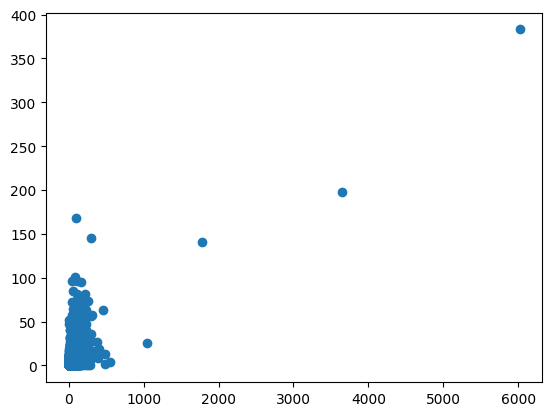

In [3]:
from matplotlib import pyplot as plt

plt.scatter(input_dataset_df['num_comments'], input_dataset_df['num_shares'])

Выглядит странно, как будто есть небольшое количество данных, больших по модулю и большое количество данных около-нулевых - такие большие элементы называют выбросами (outliers)

Строим гистограмму

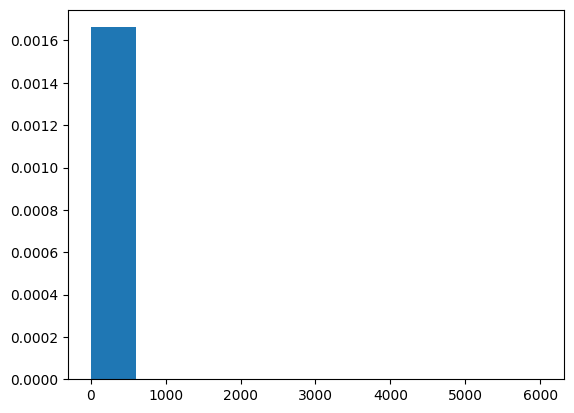

In [4]:
plt.hist(input_dataset_df['num_comments'], bins=10, density=True)
plt.show()

Выглядит странно, как будто есть небольшое количество данных, больших по модулю и большое количество данных около-нулевых - такие большие элементы называют выбросами (outliers)

Выявляем выбросы

In [5]:
input_dataset_df['num_comments'].describe(percentiles=[.5, .95, .99])

count    100000.000000
mean          3.785670
std          26.087273
min           0.000000
50%           1.000000
95%          12.000000
99%          52.000000
max        6016.000000
Name: num_comments, dtype: float64

Как ещё проверить на выбросы? С помощью `.boxplot()`


<Axes: >

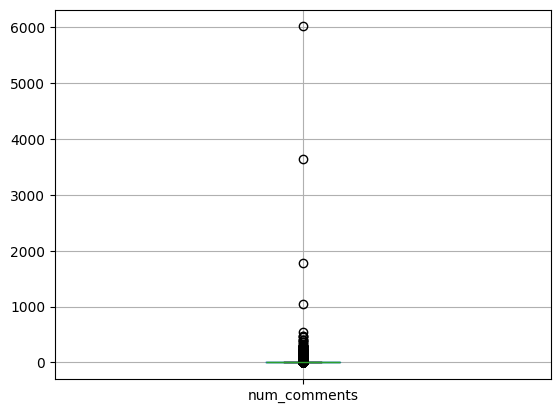

In [6]:

input_dataset_df[['num_comments']].boxplot()



Переделываем гистограмму (без выбросов)


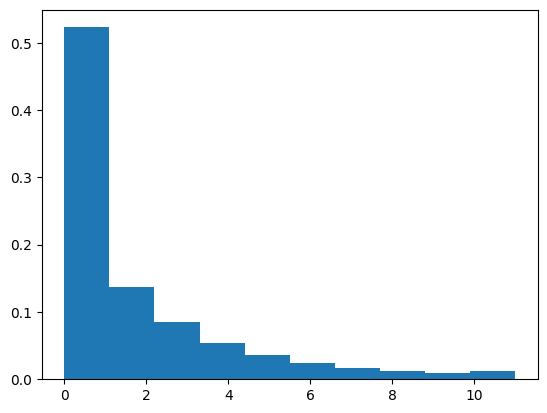

In [7]:

plt.hist(
    input_dataset_df[input_dataset_df['num_comments'] < 12]['num_comments'],
    bins=10, density=True
)
plt.show()

Получили т.н. распределение с "тяжёлым хвостом" - разберёмся как трансформировать эти данные в следующем разделе

### Пропущенные значения

В препроцессинге есть ещё один важный этап - работа с пропусками

In [8]:
null_values_share = (
    input_dataset_df['declined_reason']
    .isna()
    .value_counts(normalize=True)
    .to_dict()
    .get(True, 0.0)
)
print('Доля пропущенных значений %.4f' % null_values_share)

Доля пропущенных значений 0.7111


Заменяем `NULL` на пустую строку

In [9]:
input_dataset_df['declined_reason'].fillna(value='Value missed', inplace=True)

null_values_share = (
    input_dataset_df['declined_reason']
    .isna()
    .value_counts(normalize=True)
    .to_dict()
    .get(True, 0.0)
)
print('Доля пропущенных значений %.4f', null_values_share)
input_dataset_df['declined_reason'].value_counts()

Доля пропущенных значений %.4f 0.0


/tmp/ipykernel_85/2059529957.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  input_dataset_df['declined_reason'].fillna(value='Value missed', inplace=True)


declined_reason
Value missed                   71113
politics_religion              10102
racism                          3753
lgbt_woman_jokes                2898
not_safe_for_work               2619
Political_Lite                  1957
tragedy_death_gore_injuries     1810
watermark                       1305
call_to_harm                    1211
nudity_censored_genitals        1002
moderation_mistake               696
pedo                             460
clickbait                        442
disabilities                     213
bodily_fluids                    178
drugs                            106
school_shooting_fights            81
pepe                              38
pity                              15
jailbait                           1
Name: count, dtype: int64

### Кодирование категориальных фичей

Уже встречали этот метод в занятии по линейной регрессии - кодируем категориальные фичи

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le_transformed = le.fit_transform(input_dataset_df['declined_reason'])

pd.Series(le_transformed).value_counts().head()

1     71113
15    10102
16     3753
8      2898
10     2619
Name: count, dtype: int64

Этот метод чаще используется для анонимизации. Другой (более подходящий для линейных моделей) вид энкодинга - `OneHotEncoding`

In [11]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

ohe_transformed = ohe.fit_transform(input_dataset_df[['declined_reason']])

ohe_transformed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 100000 stored elements and shape (100000, 20)>


мы визуализировали и пофильтровали данные - можно приступать к трансформациям!

### Трансформации непрерывных фичей

В задачах линейной регрессии такие трансформации особенно важны - чтобы линейная регрессия хорошо работала должны выполняться следующие требования:

* остатки регрессии должны иметь нормальное (гауссово) распределение
* все фичи должны быть примерно в одном масшабе

При подготовке данных для обучения линейной регрессии применяются следющие приемы: масштабирование и нормализация.


Существуют чисто инженерные приёмы первичной обработки данных, например для борьбы с большими по модулю значениями обычно используют т.н. *Монотонные преобразования*:

* логарифмирование np.log
* извлечение квадратного корня np.sqrt

Оба этих преобразования являются *монотонными*, т.е. они меняют абсолютные значения, но сохраняют порядок величин.

#### z-score

Более интересный метод - это Standart Scaling или Z-score normalization. Это преобразование позволяет "сгладить" данные, избавить их от выбросов. Для этого есть инструмента [есть реализация в sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)


[]

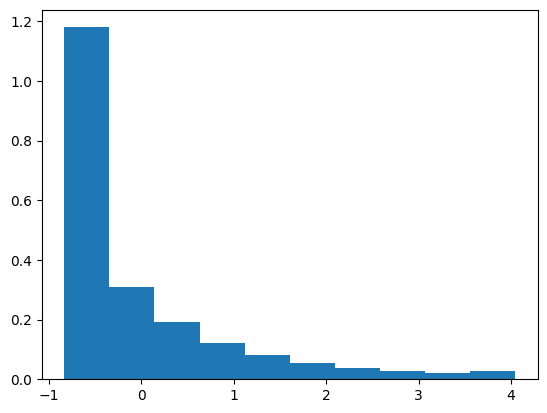

In [12]:
from sklearn.preprocessing import StandardScaler

transformed_z_score = (
    StandardScaler()
    .fit_transform(
        input_dataset_df[input_dataset_df['num_comments'] < 12]['num_comments']
        .values.reshape(-1, 1)
    )
)

plt.hist(transformed_z_score, bins=10, density=True)
plt.plot()

/tmp/ipykernel_85/1794593884.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(transformed_z_score), bins=5, density=True)


[]

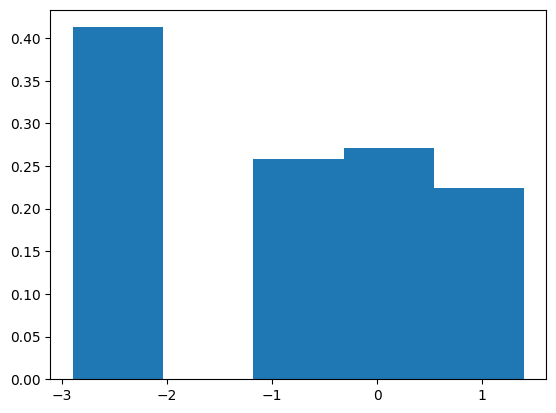

In [13]:
plt.hist(np.log(transformed_z_score), bins=5, density=True)
plt.plot()

Получили какой-то пропуск в данных, почему так вышло?

range=[-0.8310, 4.0445]


/tmp/ipykernel_85/833478351.py:6: RuntimeWarning: invalid value encountered in log
  carrier, np.log(carrier)


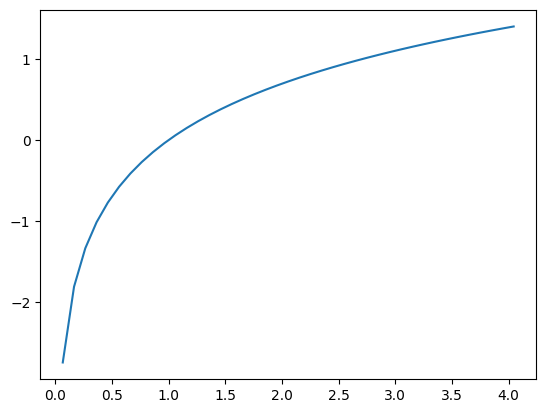

In [14]:
print('range=[%.4f, %.4f]' % (transformed_z_score.min(), transformed_z_score.max()))

carrier = np.linspace(transformed_z_score.min(), transformed_z_score.max())

plt.plot(
    carrier, np.log(carrier)
)

По графику видно, логарифм для отрицательных чисел не определён - тут нужно применить другое масштабирование, например min-max.

Получается, что логарифмирование (и извлечение квадратного корня нельзя применять после вычисления z-score)

Нужно выбрать один из вариантов
* сначала логарифмировать, а потом применить z-score
* только z-score
* только логарифмирование

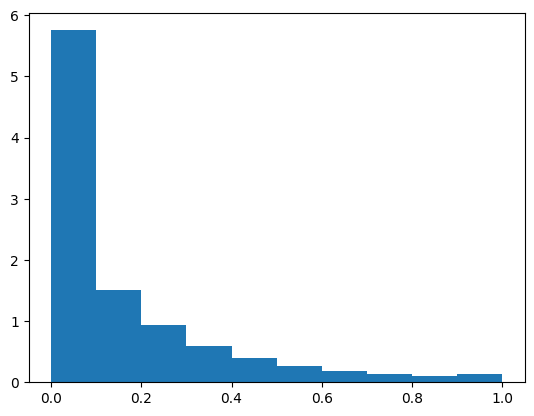

In [15]:
from sklearn.preprocessing import MinMaxScaler

transformed_z_score = (
    MinMaxScaler()
    .fit_transform(
        input_dataset_df[input_dataset_df['num_comments'] < 12]['num_comments']
        .values.reshape(-1, 1)
    )
)

plt.hist(transformed_z_score, bins=10, density=True)
plt.plot()
plt.show()

Пример трансформации на другом датасете

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro

data = pd.read_csv(os.path.join(root_data_dir, 'task.csv'))
print(data.head(3))

raw_data = data[data.columns.values[-1]].values.astype(np.float32)
print("Сырой датасет: %s" % raw_data)
print("stat = %s, p-value=%s\n" % shapiro(raw_data) )

         Код                                               Тема  \
0  HYDRA-535  Пробрасывать пользовательское распределение pa...   
1  HYDRA-534   Гибридный рекомендатель с multi-channel feedback   
2  HYDRA-532         Джоба в дженкинсе для расчёта динамики РВП   

       Компонент  Затрачено в часах  
0        echidna                  1  
1          hydra                  3  
2  hydramatrices                  2  
Сырой датасет: [ 1.  3.  2.  4.  2. 10.  2.  5.  2.  2.  1.  7.  5.  2.  5. 16. 10.  3.
 24.]
stat = 0.726285458186394, p-value=0.00011633852003649601



Проводим трансформацию фичи (масштабирование)

In [17]:
transformed_data = StandardScaler().fit_transform(raw_data.reshape(-1, 1)).reshape(-1)
print("z-transform датасет: %s" % transformed_data)
print("stat = %s, p-value=%s\n" % shapiro(transformed_data) )

print("Проверка на нормальность p_1 > p_2: %s" % (shapiro(transformed_data)[1] > shapiro(raw_data)[1]))

z-transform датасет: [-0.7986022  -0.4497874  -0.6241948  -0.27538007 -0.6241948   0.7710641
 -0.6241948  -0.10097269 -0.6241948  -0.6241948  -0.7986022   0.24784204
 -0.10097269 -0.6241948  -0.10097269  1.8175085   0.7710641  -0.4497874
  3.2127674 ]
stat = 0.7262854631758969, p-value=0.00011633853674374469

Проверка на нормальность p_1 > p_2: True


Тест Шапиро-Уилка показывает, что гипотеза о нормальном распределении данных стала чуть более вероятной, чем до "Z-score" нормализации.

#### min-max normalization

Другой распространённый метод называется MinMax Scaling. Этот метод переносит все точки на отрезок [0-1]
$$
X_{scaled} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

In [18]:
from sklearn.preprocessing import MinMaxScaler


print("Сырой датасет: %s" % raw_data)

transformed_data = MinMaxScaler().fit_transform(raw_data.reshape(-1, 1)).reshape(-1)

print("Min-Max scale датасет: %s" % transformed_data)

Сырой датасет: [ 1.  3.  2.  4.  2. 10.  2.  5.  2.  2.  1.  7.  5.  2.  5. 16. 10.  3.
 24.]
Min-Max scale датасет: [0.         0.08695652 0.04347826 0.13043478 0.04347826 0.39130437
 0.04347826 0.17391305 0.04347826 0.04347826 0.         0.2608696
 0.17391305 0.04347826 0.17391305 0.65217394 0.39130437 0.08695652
 1.        ]


### Трансформации категориальных фичей

Категориальная переменная - это набор меток (классов). В приложенном датасете по задам столбец `Компонент` - категориальная фича, а `Затрачено в часах` - непрерывная

Посчитаем количество различных меток в поле "Компонент"

In [19]:
import pandas as pd

df = pd.read_csv(os.path.join(root_data_dir, 'task.csv'))
print(df['Компонент'].value_counts().to_dict())
df.head()

{'hydra': 11, 'hydramatrices': 3, 'hydramagrices': 3, 'echidna': 1, 'hydra_utils': 1}


,Код,Тема,Компонент,Затрачено в часах
0,HYDRA-535,Пробрасывать пользовательское распределение pa...,echidna,1
1,HYDRA-534,Гибридный рекомендатель с multi-channel feedback,hydra,3
2,HYDRA-532,Джоба в дженкинсе для расчёта динамики РВП,hydramatrices,2
3,HYDRA-531,Интеграция Hydra с Gamora,hydramagrices,4
4,HYDRA-530,Тестируем интеграцию с Jira,hydra,2


#### Кодирование One-Hot

Кодируем вектор, где все нули и одна единица

In [20]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')

one_hot_encoded = ohe.fit_transform(df[['Компонент']])

one_hot_encoded.toarray()

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]])

#### Hashing trick

В случае, когда признаков слишком много, применяют хеширование



In [21]:
for label in df['Компонент'].unique():
    #print(label, '->', hash(label) % 8 )
    print(label, '->', hash(label) % 12 )

echidna -> 8
hydra -> 9
hydramatrices -> 5
hydramagrices -> 0
hydra_utils -> 1


Премер хеширования (с формулами!) в [Лекциях от ВШЭ](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture06-linclass.pdf)

Прекрасный разбор есть на хабре в статье от [ODS про feature engineering](https://habr.com/ru/company/ods/blog/326418/#rabota-s-kategorialnymi-priznakami-label-encoding-one-hot-encoding-hashing-trick)

# Трансформации данных

Получили т.н. распределение с "тяжёлым хвостом"

Данные можно центрировать и снизить дисперсию - такое преобразование называется z-score

[]

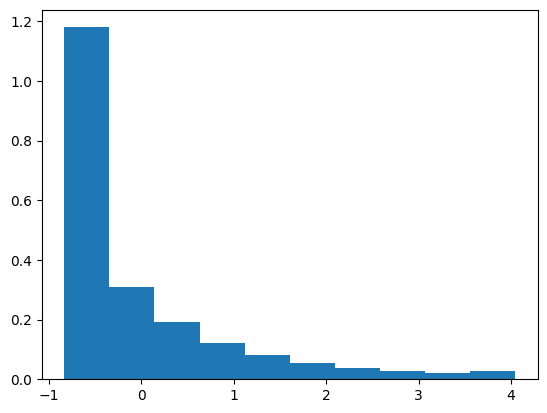

In [22]:
from sklearn.preprocessing import StandardScaler

transformed_z_score = (
    StandardScaler()
    .fit_transform(
        input_dataset_df[input_dataset_df['num_comments'] < 12]['num_comments']
        .values.reshape(-1, 1)
    )
)

plt.hist(transformed_z_score, bins=10, density=True)
plt.plot()

Можно ли применять логарифмирование всегда?

Давайте попробуем

/tmp/ipykernel_85/1794593884.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(transformed_z_score), bins=5, density=True)


[]

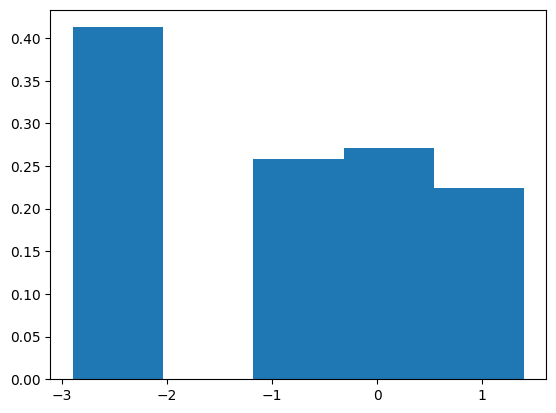

In [23]:
plt.hist(np.log(transformed_z_score), bins=5, density=True)
plt.plot()

Получили какой-то пропуск в данных, почему так вышло? Построим график логарифма для наглядности

range=[-0.8310, 4.0445]


/tmp/ipykernel_85/833478351.py:6: RuntimeWarning: invalid value encountered in log
  carrier, np.log(carrier)


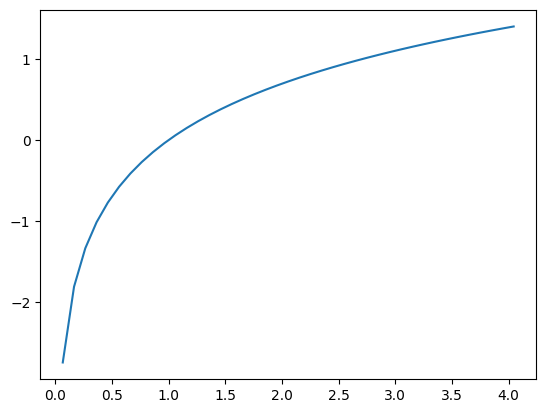

In [24]:
print('range=[%.4f, %.4f]' % (transformed_z_score.min(), transformed_z_score.max()))

carrier = np.linspace(transformed_z_score.min(), transformed_z_score.max())

plt.plot(
    carrier, np.log(carrier)
)

Получается, в numpy логарифм для отрицательных чисел не определён - тут нужно применить другое масштабирование, например min-max.

Получается, что логарифмирование (и извлечение квадратного корня нельзя применять после вычисления z-score)

Нужно выбрать один из вариантов 
* сначала логарифмировать, а потом применить z-score
* только z-score
*только логарифмирование

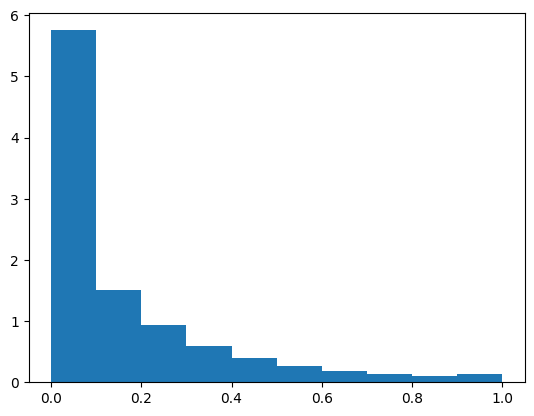

In [25]:
from sklearn.preprocessing import MinMaxScaler

transformed_z_score = (
    MinMaxScaler()
    .fit_transform(
        input_dataset_df[input_dataset_df['num_comments'] < 12]['num_comments']
        .values.reshape(-1, 1)
    )
)

plt.hist(transformed_z_score, bins=10, density=True)
plt.plot()
plt.show()

# Пропущенные значения

Проверка на пропущенные значения

In [26]:
null_values_share = (
    input_dataset_df['declined_reason']
    .isna()
    .value_counts(normalize=True)
    .to_dict()
    .get(True, 0.0)
)
print('Доля пропущенных значений %.4f' % null_values_share)

Доля пропущенных значений 0.0000


Заменяем `NULL` на пустую строку

In [27]:
input_dataset_df['declined_reason'].fillna(value='Value missed', inplace=True)

null_values_share = (
    input_dataset_df['declined_reason']
    .isna()
    .value_counts(normalize=True)
    .to_dict()
    .get(True, 0.0)
)
print('Доля пропущенных значений %.4f' % null_values_share)

Доля пропущенных значений 0.0000


In [28]:
input_dataset_df['declined_reason'].value_counts()

declined_reason
Value missed                   71113
politics_religion              10102
racism                          3753
lgbt_woman_jokes                2898
not_safe_for_work               2619
Political_Lite                  1957
tragedy_death_gore_injuries     1810
watermark                       1305
call_to_harm                    1211
nudity_censored_genitals        1002
moderation_mistake               696
pedo                             460
clickbait                        442
disabilities                     213
bodily_fluids                    178
drugs                            106
school_shooting_fights            81
pepe                              38
pity                              15
jailbait                           1
Name: count, dtype: int64

# Кодирование категориальных фичей

Кодируем категориальные фичи

In [29]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

le_transformed = le.fit_transform(input_dataset_df['declined_reason'])

pd.Series(le_transformed).value_counts().head()

1     71113
15    10102
16     3753
8      2898
10     2619
Name: count, dtype: int64

Другой (более подходящий) вид энкодинга

In [30]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()

ohe_transformed = ohe.fit_transform(input_dataset_df[['declined_reason']])

ohe_transformed

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 100000 stored elements and shape (100000, 20)>

# Текстовые фичи

## Bag of words

In [68]:
[i for i in os.listdir(root_data_dir) if 'tweet' in i]

['brand_tweets.csv', 'brand_tweets_valid.csv']

In [70]:
import pandas as pd

ocr_dataset_df = pd.read_csv(os.path.join(root_data_dir, 'brand_tweets.csv'))
print('num rows %d' % ocr_dataset_df.shape[0])

ocr_dataset_df.head()

num rows 3905


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [73]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    analyzer='word',
    lowercase=True,
    token_pattern=r'\b[\w\d]{3,}\b',
    min_df=0.001
)

bow_matrix = vectorizer.fit_transform(ocr_dataset_df['tweet_text'].fillna('').values)
bow_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 45048 stored elements and shape (3905, 1516)>

По sparse матрице можно найти попарное расстояние между текстами

In [74]:
from sklearn.metrics import pairwise_distances

text_distance = 1 - pairwise_distances(bow_matrix, metric="cosine")

text_distance.shape

(3905, 3905)

Мы получили квадратную матрицy, которая содержит столько строк и столбцов, сколько документов в нашем корпусе (наборе текстов).

Зачем нужна такая матрица? Например, можно искать "похожие" тексты для задачи рекомендаций

In [76]:
source_tweet_index = 14  # тут может быть любое число в диапазоне от 1 до 1000

print(ocr_dataset_df.iloc[source_tweet_index]['tweet_text'])

Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l


Находим ближайший похожий текст

отсортируем твиты по “похожести” - чем похожее на `source_tweet_index`, тем ближе к началу списка sorted_similarity

In [77]:
sorted_similarity = np.argsort(-1 * text_distance[source_tweet_index,:])

sorted_similarity[:10]

array([  14, 1963,   30, 2265,   15,   26,   23,    8,   31, 1139])

Теперь распечаем "схожие" тексты

In [79]:
for content_index in sorted_similarity[:4]:
  print(ocr_dataset_df.iloc[content_index]['tweet_text'])
  print('-------------\n-------------')

Great #sxsw ipad app from @madebymany: http://tinyurl.com/4nqv92l
-------------
-------------
Holler Gram for iPad on the iTunes App Store: {link} via @mention all you #SXSW-sters great App from #MadebyMany - Free
-------------
-------------
Very smart from @madebymany #hollergram iPad app for #sxsw! http://t.co/A3xvWc6 (may leave my vuvuzela at home now)
-------------
-------------
RT globalbestaward Holler Gram for iPad on iTunes Store: {link} via @mention all you #SXSW-sters great App from #MadebyMany
-------------
-------------


## Препроцессинг текста

Устанавливаем NLTK. Для начала готовим директорию для данных

In [80]:
run_env = os.getenv('RUN_ENV', 'COLLAB')
if run_env == 'COLLAB':
    nltk_data_dir = os.path.join(root_data_dir, 'nltk_data')
    if not os.path.exists(nltk_data_dir):
      os.makedirs(nltk_data_dir)
      logger.info('Директория %s создана', nltk_data_dir)
    logs_dir = os.path.join(ROOT_DIR, 'MyDrive', 'hse_nlp_2021', 'logs')
    if not os.path.exists(logs_dir):
      os.makedirs(logs_dir)
    logger.info('Подготовили директорию для nltk %s', nltk_data_dir)
print('NLTK dir was prepared')

NLTK dir was prepared


In [81]:
import nltk

nltk.download('punkt', download_dir=nltk_data_dir)
nltk.data.path.append(nltk_data_dir) # тут почему-то корневую надо указывать ¯\_(ツ)_/¯

[nltk_data] Downloading package punkt to /opt/ml/data/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [83]:
import nltk

sample_str = ocr_dataset_df['tweet_text'].values[0]

print('== Исходный текст== \n%s\n\n' % sample_str)

tokenized_str = nltk.word_tokenize(sample_str)
print('== Токенизированный текст==\n%s' % tokenized_str)

== Исходный текст== 
.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.


== Токенизированный текст==
['.', '@', 'wesley83', 'I', 'have', 'a', '3G', 'iPhone', '.', 'After', '3', 'hrs', 'tweeting', 'at', '#', 'RISE_Austin', ',', 'it', 'was', 'dead', '!', 'I', 'need', 'to', 'upgrade', '.', 'Plugin', 'stations', 'at', '#', 'SXSW', '.']


Видим знаки препинания, надо их отфильтровать

In [84]:
import string  # стандартный модуль

tokens = [i.lower() for i in tokenized_str if ( i not in string.punctuation )]
print(tokens)

['wesley83', 'i', 'have', 'a', '3g', 'iphone', 'after', '3', 'hrs', 'tweeting', 'at', 'rise_austin', 'it', 'was', 'dead', 'i', 'need', 'to', 'upgrade', 'plugin', 'stations', 'at', 'sxsw']


Стоп-слова

In [85]:
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
    'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'shold',
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
    'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"
]

filtered_tokens = [i for i in tokens if ( i not in stop_words )]

print(filtered_tokens)

['wesley83', '3g', 'iphone', '3', 'hrs', 'tweeting', 'rise_austin', 'dead', 'need', 'upgrade', 'plugin', 'stations', 'sxsw']


Соединяем в одну функцию

In [88]:
def tokenize_text(raw_text: str):
    """Функция для токенизации текста
    
    :param raw_text: исходная текстовая строка
    """
    filtered_tokens = []
    
    filtered_tokens = [i.lower() for i in raw_text.split() if ( i not in string.punctuation )]
    filtered_tokens = [i for i in filtered_tokens if ( i not in stop_words )]
    filtered_tokens = [i for i in filtered_tokens if ( len(i) > 2 )]
    
    return filtered_tokens

# применяем функцию в датафрейму с помощью метода .apply()
tokenized_tweets= ocr_dataset_df['tweet_text'].fillna('').apply(tokenize_text)

# добавляем новую колонку в исходный датафрейм
ocr_dataset_df = ocr_dataset_df.assign(
    tokenized=tokenized_tweets
)

ocr_dataset_df.tokenized.head()

0    [.@wesley83, iphone., hrs, tweeting, #rise_aus...
1    [@jessedee, know, @fludapp, awesome, ipad/ipho...
2    [@swonderlin, wait, #ipad, also., should, sale...
3    [@sxsw, hope, year's, festival, crashy, year's...
4    [@sxtxstate, great, stuff, fri, #sxsw:, mariss...
Name: tokenized, dtype: object

## Эмбеддинги Word2Vec

In [89]:
from gensim.models import Word2Vec
import logging

texts = ocr_dataset_df.tokenized.values

model = Word2Vec(texts, vector_size=10, window=7, min_count=2, workers=4, epochs=10, sg=0)
print('Model trained')

Model trained


Эмбеддинги обучились, посмотрим как они выглядят

In [90]:
model.wv.get_vector('android')

array([ 0.93474406, -0.5899314 ,  1.964192  ,  1.1705691 ,  1.101795  ,
       -0.7931788 ,  2.05619   ,  1.2247944 , -4.022227  , -0.5167159 ],
      dtype=float32)

Проверяем эмбеддинги - ищем эмбеддинг, самый похожий на эмбеддинг слова Biden

In [93]:
# biden
# model.wv.most_similar('biden')
model.wv.most_similar('android')

[('confession,', 0.9925059080123901),
 ('started', 0.9897639751434326),
 ('listening', 0.9894517660140991),
 ('interface', 0.9893234372138977),
 ('stuff!', 0.9888144731521606),
 ('iphone', 0.9887372851371765),
 ('#gsdm', 0.9883440136909485),
 ('team', 0.9883101582527161),
 ('feeling', 0.9882416725158691),
 ('ranking', 0.9881197810173035)]